# Tutorial: O-ring Failure Rates Prior to the Challenger Shuttle Loss
## Coping with missing information

In this tutorial, we will use a real data set where unwise interpretation of incomplete data had serious consequences to illustrate how such selection effects could be modeled. You will

* implement and fit a simple model for the probability of O-ring failure as a function of ambient temperature, assuming a complete data set;
* modify the model to account for censoring of the data;
* modify the model further to account for truncation of the data set;
* compare the inferences following from each of these models.

## Background

On January 28, 1986, the Space Shuttle Challenger was destroyed in an explosion during launch. The cause was eventually found to be the failure of an O-ring seal that normally prevents hot gas from leaking between two segments of the solid rocket motors during their burn. The ambient atmospheric temperature of just 36 degrees Fahrenheit,  significantly colder than any previous launch, was determined to be a significant factor in the failure.

A relevant excerpt from the [Report of the Presidential Commission on the Space Shuttle Challenger Accident](https://history.nasa.gov/rogersrep/genindex.htm) reads:

> #### Temperature Effects

> The record of the fateful series of NASA and Thiokol meetings, telephone conferences, notes, and facsimile transmissions on January 27th, the night before the launch of flight 51L, shows that only limited consideration was given to the past history of O-ring damage in terms of temperature. The managers compared as a function of temperature the flights for which thermal distress of O-rings had been observed-not the frequency of occurrence based on all flights (Figure 6). In such a comparison, there is nothing irregular in the distribution of O-ring "distress" over the spectrum of joint temperatures at launch between 53 degrees Fahrenheit and 75 degrees Fahrenheit. When the entire history of flight experience is considered, including"normal" flights with no erosion or blow-by, the comparison is substantially different (Figure 7).

> This comparison of flight history indicates that only three incidents of O-ring thermal distress occurred out of twenty flights with O-ring temperatures at 66 degrees Fahrenheit or above, whereas, all four flights with O-ring temperatures at 63 degrees Fahrenheit or below experienced O-ring thermal distress.

> Consideration of the entire launch temperature history indicates that the probability of O-ring distress is increased to almost a certainty if the temperature of the joint is less than 65.

<table>
    <tr>
        <td><img src="graphics/v1p146.jpg" width=75% alt="Top: number of incidents as a function of temperature, showing only launches with at least 1 incident; Bottom: same, including launches that suffered 0 incidents"></td>
    </tr>
</table>

The data above show the number of incidences of O-ring damage found in previous missions as a function of the temperature at launch; these have been transcribed below.

In [1]:
TutorialName = 'missing_data'
exec(open('tbc.py').read()) # define TBC and TBC_above
from io import StringIO
import numpy as np
from pygtc import plotGTC
import emcee
import incredible as cr
import matplotlib.pyplot as plt
%matplotlib inline

The data in the figure above are transcribed and read into an array here. We store the launch temperatures in `oring_temps` and the corresponding number of incidents in `oring_incidents`.

In [2]:
oring_data_string = \
"""# temperature incidents
53 3
56 1
57 1
63 1
66 0
67 0
67 0
67 0
68 0
69 0
70 1
70 1
70 0
70 0
72 0
73 0
75 2
75 0
76 0
76 0
78 0
79 0
80 0
81 0
"""
oring_data = np.loadtxt(StringIO(oring_data_string), skiprows=1)
oring_temps = oring_data[:,0]
oring_incidents = oring_data[:,1]

Here's a quick plot to show that we did that right (cf above).

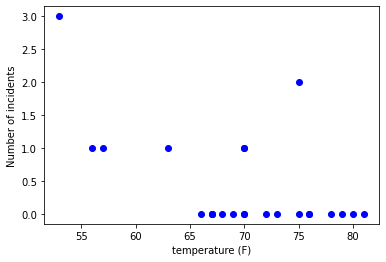

In [3]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(oring_temps, oring_incidents, 'bo');
plt.xlabel('temperature (F)');
plt.ylabel('Number of incidents');

For this notebook, we will simplify the data for each launch from integer (how many incidents of O-ring damage) to boolean (was there any damage, or not). This cell stores the temperatures corresponding to "failure" (any incidents) and "success" (no incidents).

In [4]:
failure_temps = oring_temps[np.where(oring_incidents > 0)[0]]
Nfailure = len(failure_temps)
success_temps = oring_temps[np.where(oring_incidents == 0)[0]]
Nsuccess = len(success_temps)
print('temperatures corresponding to failures:', failure_temps)
print('temperatures corresponding to successes:', success_temps)

temperatures corresponding to failures: [53. 56. 57. 63. 70. 70. 75.]
temperatures corresponding to successes: [66. 67. 67. 67. 68. 69. 70. 70. 72. 73. 75. 76. 76. 78. 79. 80. 81.]


## 1. Defining a model

Before worrying about missing data, let's define a model that we might want to fit to the complete data. We're interested in whether the probability of having zero O-ring incidents (or non-zero incidents, conversely) is a function of temperature. One possible parametrization that allows this is the [logistic function](https://en.wikipedia.org/wiki/Logistic_function), which squeezes the real line onto the range (0,1).

For reasons that may be clear later, I suggest defining the model in terms of the probability of success (zero incidents)

$P_\mathrm{success}(T|T_0,\beta,P_\mathrm{cold},P_\mathrm{hot}) = P_\mathrm{cold} + \frac{P_\mathrm{hot} - P_\mathrm{cold}}{1 + e^{-\beta(T-T_0)}}$,

with parameters $T_0$ and $\beta$ respectively determining the center and width of the logistic function, and $P_\mathrm{cold}$ and $P_\mathrm{hot}$ determine the probabilities of success at very low and high temperatures (which need not be 0 or 1).

As we'll see in a moment, a model like this provides a smooth, linear-ish transition between two extreme values, without imposing the strong prior that $P_\mathrm{success}$ _must_ drop to zero at some point, for example.

### 1a. Implement this function and have a look

In [6]:
def P_success(T, T0, beta, Pcold, Phot):
    return Pcold+(Phot-Pcold)/(1+np.exp(-beta*(T-T0)))

Plot the function for a few different parameter values. If you've never worked with the logistic function (or a similar _sigmoid_ function) before, this will give you an idea of how flexible it is.

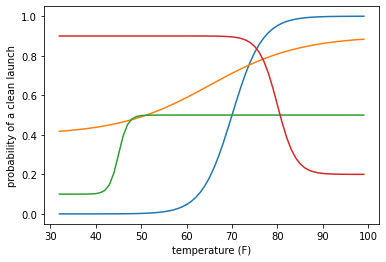

In [7]:
plt.rcParams['figure.figsize'] = (6, 4)
T_axis = np.arange(32., 100.)
plt.plot(T_axis, P_success(T_axis, 70.0, 0.3, 0.0, 1.0));
plt.plot(T_axis, P_success(T_axis, 65.0, 0.1, 0.4, 0.9));
plt.plot(T_axis, P_success(T_axis, 45.0, 1.0, 0.1, 0.5));
plt.plot(T_axis, P_success(T_axis, 80.0, 0.5, 0.9, 0.2));
plt.xlabel('temperature (F)');
plt.ylabel('probability of a clean launch');

### 1b. PGM and priors

Given the definition of the data and model above, draw the PGM for this problem, write down the corresponding probability expressions, and write down the likelihood (all assuming we have the complete data set).

In [ ]:
TBC() # answer in Markdown

Choosing priors is a little tricky because we're interested in the model's predictions at $T=36$ degrees F, which is an extrapolation even for the complete data set.

We'd like our model to be consistent with no trend a priori - that way we can see relatively straightforwardly whether the _data_ require there to be a trend. A pleasingly symmetric way to allow this is to put identical, independent priors on $P_\mathrm{cold}$ and $P_\mathrm{hot}$, in particular including the possibility that $P_\mathrm{cold} > P_\mathrm{hot}$ even though that isn't what we're looking for. Thus, a solution with $P_\mathrm{cold}=P_\mathrm{hot}$, i.e. no trend, is perfectly allowed.

Our temperature data are given in integer degrees, so it doesn't make sense to allow values of $\beta$ too much greater than 1, since the data would not resolve such a sudden change (which would increasingly make $P_\mathrm{success}$ resemble a step function). By definition, $\beta>0$ (it's a "rate" parameter).

In principle, we might allow $T_0$ to take any value. But, arguably, the most sensible thing we can do with such limited information is test whether there is evidence for a trend in the probability of O-ring failure _within the range of the available data_ (or, a little more casually, the range of the figure from the report, above). Given the flexibility already provided by the choices above, there's little obvious benefit to allowing $T_0$ to vary more than this.

In summary, my suggestion is the following uniform priors:
* $0<P_\mathrm{cold}<1$
* $0<P_\mathrm{hot}<1$
* $0<\beta<3$
* $45<T_0<80$

As always, you're welcome to mess around with other priors if you disagree. However, for the work you turn in, use the priors above.

Implement a log-prior function below.

In [8]:
def ln_prior(T0, beta, Pcold, Phot):
    if 0<Pcold<1 and 0<Phot<1 and 0<beta<3 and 45<T0<80:
        return 0
    return -np.inf

### 1c. Model fitting code

Since the point of this tutorial is model design rather than carrying out a fit, a bunch of code is given below. Naturally, you should ensure that you understand what the code is doing, even though there's nothing to add.

Here we follow a similar, though simpler, approach to the object oriented code used in the model evaluation/selection notebooks, since the models we'll compare all have the same set of free parameters. The `Model` object will take log-prior and log-likelihood functions as inputs in its constructor (instead of deriving new classes corresponding to different likelihoods), and will deal with the computational aspects of fitting the parameters. It will also provide a posterior prediction for the thing we actually care about, the failure probability at a given temperature. To do this, we need to marginalize over the model parameters; that is, we compute the posterior-weighted average of $1-P_\mathrm{success}$, at some temperature of interest, over the parameter space.

In [9]:
class Model:
    def __init__(self, log_prior, log_likelihood):
        self.log_prior = log_prior
        self.log_likelihood = log_likelihood
        self.param_names = ['T0', 'beta', 'Pcold', 'Phot']
        self.param_labels = [r'$T_0$', r'$\beta$', r'$P_\mathrm{cold}$', r'$P_\mathrm{hot}$']
        self.sampler = None
        self.samples = None
    def log_posterior(self, pvec=None, **params):
        '''
        Our usual log-posterior function, able to take a vector argument to satisfy emcee
        '''
        if pvec is not None:
            pdict = {k:pvec[i] for i,k in enumerate(self.param_names)}
            return self.log_posterior(**pdict)
        lnp = self.log_prior(**params)
        if lnp != -np.inf:
            lnp += self.log_likelihood(**params)
        return lnp
    def sample_posterior(self, nwalkers=8, nsteps=10000, guess=[65.0, 0.1, 0.25, 0.75], threads=1):
        # use emcee to sample the posterior
        npars = len(self.param_names)
        self.sampler = emcee.EnsembleSampler(nwalkers, npars, self.log_posterior, threads=threads)
        start = np.array([np.array(guess)*(1.0 + 0.01*np.random.randn(npars)) for j in range(nwalkers)])
        self.sampler.run_mcmc(start, nsteps)
        plt.rcParams['figure.figsize'] = (16.0, 3.0*npars)
        fig, ax = plt.subplots(npars, 1);
        cr.plot_traces(self.sampler.chain[:min(8,nwalkers),:,:], ax, labels=self.param_labels);
    def check_chains(self, burn=500, maxlag=500):
        '''
        Ignoring `burn` samples from the front of each chain, compute convergence criteria and
        effective number of samples.
        '''
        nwalk, nsteps, npars = self.sampler.chain.shape
        if burn < 1 or burn >= nsteps:
            return
        tmp_samples = [self.sampler.chain[i,burn:,:] for i in range(nwalk)]
        print('R =', cr.GelmanRubinR(tmp_samples))
        print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))
        print('NB: Since walkers are not independent, these will be optimistic!')
    def remove_burnin(self, burn=500):
        '''
        Remove `burn` samples from the front of each chain, and concatenate.
        Store the result in self.samples.
        '''
        nwalk, nsteps, npars = self.sampler.chain.shape
        if burn < 1 or burn >= nsteps:
            return
        self.samples = self.sampler.chain[:,burn:,:].reshape(nwalk*(nsteps-burn), npars)
    def posterior_prediction_Pfailure(self, temperatures=np.arange(30., 85.), probs=[0.5, 0.16, 0.84]):
        '''
        For the given temperatures, compute and store quantiles of the posterior predictive distribution for O-ring failure.
        By default, return the median and a 68% credible interval (defined via quantiles).
        '''
        Pfail = np.array([1.0-P_success(T, self.samples[:,0], self.samples[:,1], self.samples[:,2], self.samples[:,3]) for T in temperatures])
        res = {'T':temperatures, 'p':[str(p) for p in probs]}
        for p in probs:
            res[str(p)] = np.quantile(Pfail, p, axis=1)
        self.post_failure = res
    def plot_Pfailure(self, color, label):
        '''
        Plot summaries of the posterior predictive distribution for O-ring failure.
        Show the center as a solid line and credible interval(s) bounded by dashed lines.
        '''
        plt.plot(self.post_failure['T'], self.post_failure[self.post_failure['p'][0]], color+'-', label=label)
        n = len(self.post_failure['p'])
        if n > 1:
            for j in range(1,n):
                plt.plot(self.post_failure['T'], self.post_failure[self.post_failure['p'][j]], color+'--')

## 2. Solution for complete data

First, let's see what the solution looks like when there are no missing data. Complete the likelihood function appropriate for a complete data set below.

In [10]:
failure_temps

array([53., 56., 57., 63., 70., 70., 75.])

In [11]:
success_temps

array([66., 67., 67., 67., 68., 69., 70., 70., 72., 73., 75., 76., 76.,
       78., 79., 80., 81.])

$P_\mathrm{success}(T|T_0,\beta,P_\mathrm{cold},P_\mathrm{hot}) = P_\mathrm{cold} + \frac{P_\mathrm{hot} - P_\mathrm{cold}}{1 + e^{-\beta(T-T_0)}}$,


In [54]:
def ln_like_complete(T0, beta, Pcold, Phot):
    """
    Return the log-likelihood corresponding to a complete data set
    """
    return np.sum(np.log(P_success(oring_temps, T0, beta, Pcold, Phot)))

Now we put the `Model` code to work. The default options below _should_ work well enough, but do keep an eye the usual basic diagnostics as provided below, and make any necessary changes. First we instantiate the model...

In [55]:
complete_model = Model(ln_prior, ln_like_complete)

... and run the fit. Note that the parameters are not likely to be individually well contrained by the data, compared with the prior. We don't necessarily care about this - the important question is what the posterior predictive distribution for the probability of failure at a given temperature looks like. (We do, or course, need the chains to be converged and adequately sampled, however.)

CPU times: user 9.59 s, sys: 215 ms, total: 9.8 s
Wall time: 11.5 s


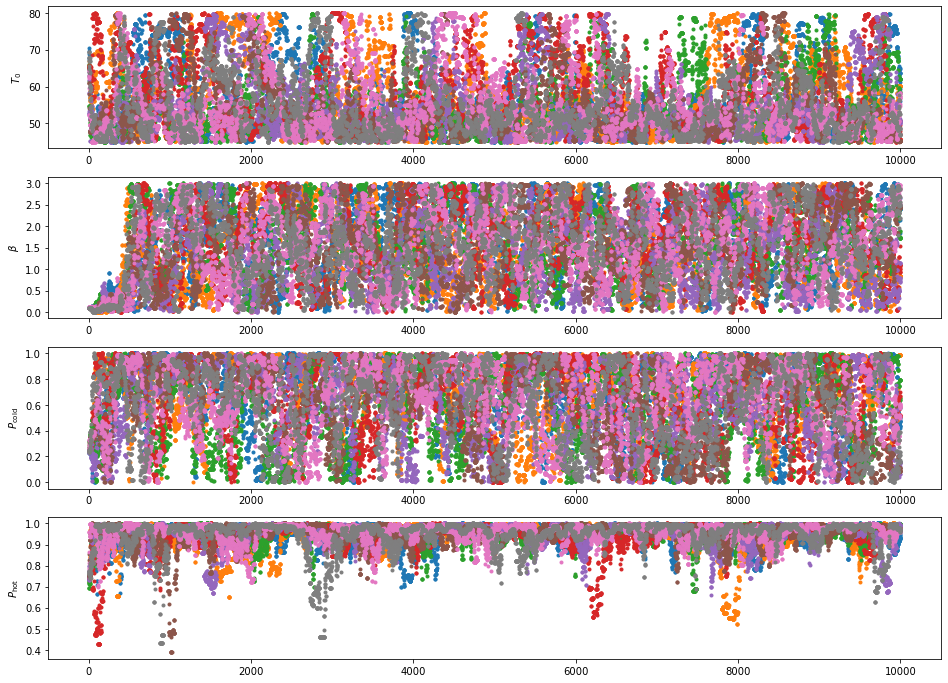

In [56]:
%%time
complete_model.sample_posterior(nwalkers=8, nsteps=10000, guess=[65.0, 0.1, 0.25, 0.75])

Here are the usual diagnostics:

In [57]:
complete_model.check_chains(burn=1000, maxlag=2000)

R = [1.008077   1.00747451 1.00714986 1.00595505]
neff = [294.58898784 472.80666186 386.19354811 280.68721812]
NB: Since walkers are not independent, these will be optimistic!


Finally, remove burn-in and plot the marginal posteriors:

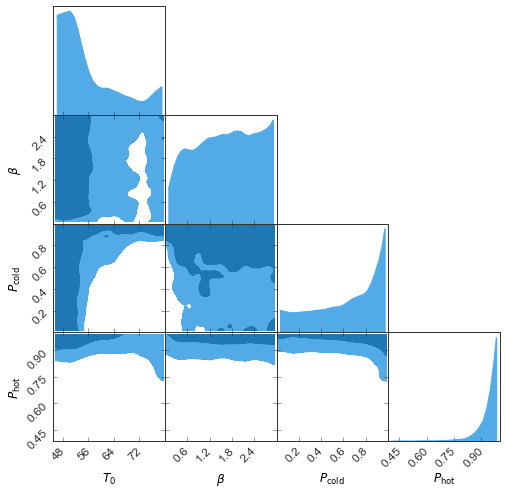

In [58]:
complete_model.remove_burnin(burn=1000)
plotGTC(complete_model.samples, paramNames=complete_model.param_labels,
       figureSize=8, customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

Assuming that went well, let's visualize the predicted failure probability as a function of temperature. The solid and dashed lines show the posterior-predictive median and and percentile-based 68% credible interval for $P_\mathrm{failure} = 1 - P_\mathrm{success}$ at each temperature.

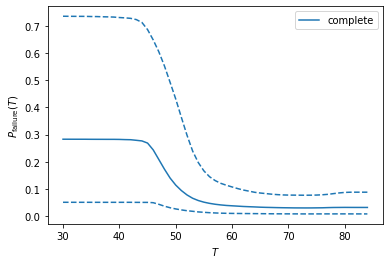

In [59]:
complete_model.posterior_prediction_Pfailure()

plt.rcParams['figure.figsize'] = (6., 4.)
complete_model.plot_Pfailure('C0', 'complete')
plt.xlabel(r'$T$');
plt.ylabel(r'$P_\mathrm{failure}(T)$');
plt.legend();

Does this make curve sense compared with inspection of the data? Any surprises?

**Checkpoint:** Let's look at the probability of failure at 36 F. This will print the posterior prediction median and CI lower and upper bounds. For comparison, I find approximately $0.83_{-0.25}^{+0.13}$.

In [60]:
j = np.where(complete_model.post_failure['T']==36.)[0]
thing = [float(complete_model.post_failure[p][j]) for p in complete_model.post_failure['p']]
print('Pfailure(T=36F|data) =', round(thing[0],2), '+'+str(round(thing[2]-thing[0],2)), round(thing[1]-thing[0],2))

Pfailure(T=36F|data) = 0.28 +0.45 -0.23


## 3. Censored (but somewhat informed) success temperatures

Imagine we are in a slightly better situation than that shown in the top panel of Figure 6 from the report. Namely, we are given
1. the temperatures of launches where there were O-ring failures (`failure_temps` and `Nfailure` above),
2. the number of launches with no failures (`Nsuccess = len(success_temps)`),
3. a range of temperatures containing the successful launches, but **not** the precise temperatures of each.

For (3), we'll just use the actual min and max of `success_temps`, and implementing the prior on unknown temperatures as uniform in this range. In the next section, we'll look at the results with a less informed prior on the success temperatures.

In [41]:
success_Tmin = np.min(success_temps)
success_Tmax = np.max(success_temps)
Nsuccess = len(success_temps)

### 3a. Censored model definition

Work out how to adjust your PGM and expression for the likelihood to reflect our ignorance of the temperatures of successful launches.

Implement the (log)-likelihood for the censored model. Here are some hints/suggestions if you want them:
1. This doesn't require as dramatic a change to the model as truncation would, more a re-definition of the sampling distribution for the censored points.
2. A model component that was previously fixed by observation or effectively determined precisely is now indeterminate.
3. We can marginalize over our newfound ignorance analytically, taking advantage of the fact that the integral of the logistic function is analytic ([see Wikipedia](https://en.wikipedia.org/wiki/Logistic_function)).

In [46]:
print("failure_temps = ", failure_temps)
print("NSuccess = ",Nsuccess,"success_Tmin = ",success_Tmin,"success_Tmax = ",success_Tmax)

failure_temps =  [53. 56. 57. 63. 70. 70. 75.]
NSuccess =  17 success_Tmin =  66.0 success_Tmax =  81.0


$P_\mathrm{success}(T|T_0,\beta,P_\mathrm{cold},P_\mathrm{hot}) = P_\mathrm{cold} + \frac{P_\mathrm{hot} - P_\mathrm{cold}}{1 + e^{-\beta(T-T_0)}}$,


In [70]:
def ln_like_censored(T0, beta, Pcold, Phot):
    """
    Return the log-likelihood for the case of censored success temperatures.
    This prototype assumes the success temperatures will be marginalized over within this function; otherwise
    they would need to be additional parameters to be sampled.
    """
    margin_p=np.log(1+np.exp(success_Tmax))-np.log(1+np.exp(success_Tmin))
    return np.sum(np.log(P_success(failure_temps, T0, beta, Pcold, Phot)))+np.log(margin_p)


### 3b. Censored model fit

We can now carry out the usual steps. Again, the choices made below will _probably_ work, but change them if need be **and check the usual diagnostics**.

In [71]:
censored_model = Model(ln_prior, ln_like_censored)

CPU times: user 10.4 s, sys: 428 ms, total: 10.8 s
Wall time: 12.5 s


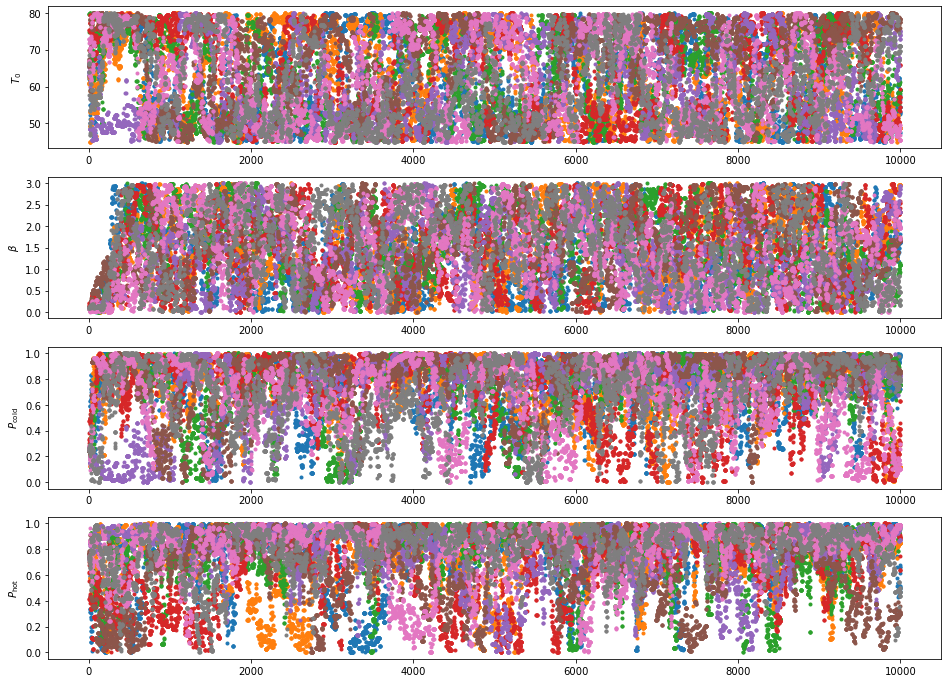

In [72]:
%%time
censored_model.sample_posterior(nwalkers=8, nsteps=10000, guess=[65.0, 0.1, 0.25, 0.75])

In [73]:
censored_model.check_chains(burn=1000, maxlag=2000)

R = [1.01981717 1.01397073 1.02213137 1.0191819 ]
neff = [227.10521523 294.97159282 158.94515151 215.819326  ]
NB: Since walkers are not independent, these will be optimistic!


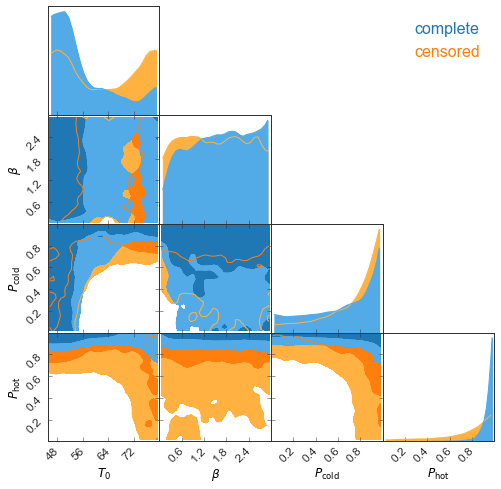

In [74]:
censored_model.remove_burnin(burn=1000)
plotGTC([complete_model.samples, censored_model.samples], paramNames=complete_model.param_labels,
        chainLabels=['complete', 'censored'],
        figureSize=8, customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

Now let's compare the posterior predictions to the previous result.

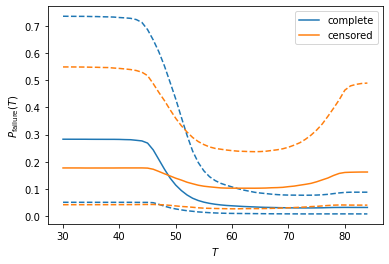

In [75]:
censored_model.posterior_prediction_Pfailure()

plt.rcParams['figure.figsize'] = (6., 4.)
complete_model.plot_Pfailure('C0', 'complete')
censored_model.plot_Pfailure('C1', 'censored')
plt.xlabel(r'$T$');
plt.ylabel(r'$P_\mathrm{failure}(T)$');
plt.legend();

Does your censored model manage to make consistent predictions to the model fitted to the complete data? If there are clear differences, do they make sense in light of what information has been hidden? Is there still evidence for a temperature-dependent failure rate?

In [ ]:
TBC() # answer in Markdown

**Checkpoint:** Looking at a balmy temperature of 75 F this time, I find a failure probability of approximately $0.18_{-0.08}^{+0.10}$.

In [76]:
j = np.where(censored_model.post_failure['T']==75.)[0]
thing = [float(censored_model.post_failure[p][j]) for p in censored_model.post_failure['p']]
print('Pfailure(T=75F|data) =', round(thing[0],2), '+'+str(round(thing[2]-thing[0],2)), round(thing[1]-thing[0],2))

Pfailure(T=75F|data) = 0.13 +0.19 -0.09


## 4. Censored (less informed) success temperatures

As a point of comparison, let's fit a model in which the temperature range for the censored (success) data is much less well constrained. This is arguably more analogous to what we might do by eye if presented with the first figure in this notebook, knowing that successful launches were absent from the figure, but without the context that those launches has all taken place in warm weather.

In particular, let's take the prior on the success temperatures to be uniform over the range shown in the figure. We followed poor practice by defining `success_Tmin` and `success_Tmax` at global scope earlier, and then using them from global scope in `ln_like_censored`, but it does mean we can just redefine them below and then re-use the likelihood function. If your implementation differs (i.e., was more sensible), you might need to change some more details.

In [77]:
success_Tmin = 45.0
success_Tmax = 80.0

In [78]:
verycensored_model = Model(ln_prior, ln_like_censored)

CPU times: user 12.8 s, sys: 190 ms, total: 13 s
Wall time: 18.2 s


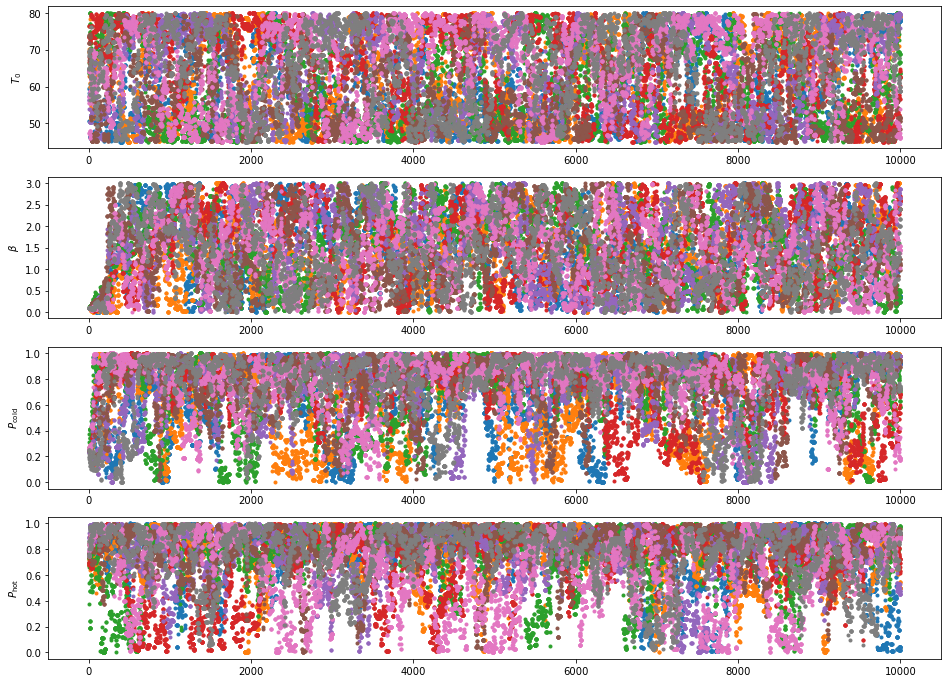

In [79]:
%%time
verycensored_model.sample_posterior(nwalkers=8, nsteps=10000, guess=[65.0, 0.1, 0.25, 0.75])

In [80]:
verycensored_model.check_chains(burn=1000, maxlag=2000)

R = [1.02832772 1.00630834 1.01598848 1.03449621]
neff = [214.52551819 405.53594664 242.14935963 193.10612691]
NB: Since walkers are not independent, these will be optimistic!


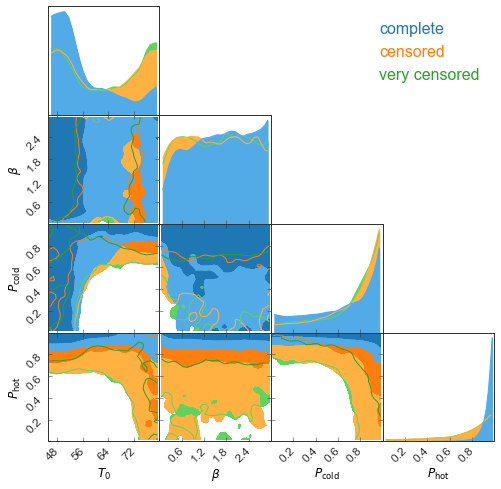

In [81]:
verycensored_model.remove_burnin(burn=1000)
plotGTC([complete_model.samples, censored_model.samples, verycensored_model.samples], paramNames=complete_model.param_labels,
        chainLabels=['complete', 'censored', 'very censored'],
        figureSize=8, customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

This seems like it will lead to somewhat different posterior predictions. Let's check.

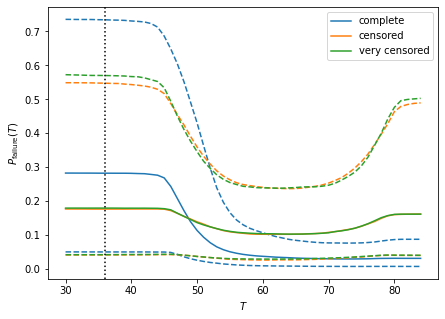

In [82]:
verycensored_model.posterior_prediction_Pfailure()

plt.rcParams['figure.figsize'] = (7., 5.)
complete_model.plot_Pfailure('C0', 'complete')
censored_model.plot_Pfailure('C1', 'censored')
verycensored_model.plot_Pfailure('C2', 'very censored')
plt.axvline(36.0, color='k', linestyle='dotted')
plt.xlabel(r'$T$');
plt.ylabel(r'$P_\mathrm{failure}(T)$');
plt.legend();

The vertical, dotted line added in this plot marks the ambient temperature of 36 F at the Challenger launch.

Does this more censored model manage to make consistent predictions to the model fitted to the complete data? If there are clear differences, do they make sense in light of what information has been hidden?  Is there still evidence for a temperature-dependent failure rate?

In [ ]:
TBC() # answer in Markdown

**Checkpoint:** looking now at 60 F, I find a failure probability of approximately $0.32_{-0.10}^{+0.11}$.

In [83]:
j = np.where(verycensored_model.post_failure['T']==60.)[0]
thing = [float(verycensored_model.post_failure[p][j]) for p in verycensored_model.post_failure['p']]
print('Pfailure(T=60F|data) =', round(thing[0],2), '+'+str(round(thing[2]-thing[0],2)), round(thing[1]-thing[0],2))

Pfailure(T=60F|data) = 0.1 +0.14 -0.07


## 5. Draw a conclusion

In light of all your work above, comment on the report's assertion that "Consideration of the entire launch temperature history indicates that the probability of O-ring distress is increased to almost a certainty if the temperature of the joint is less than 65."